In [1]:
%matplotlib inline
from time import time
import os.path as op
import gzip
import numpy as np
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt

/srv/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Computational environment

In [2]:
try:
    tfe.enable_eager_execution()
except ValueError:
    pass

def get_data_format():
    return 'channels_first' if tfe.num_gpus() else 'channels_last'

def get_device():
    return "gpu:0" if tfe.num_gpus() else "cpu:0"


print(get_device(), get_data_format())

cpu:0 channels_last


## Data preparation

In [3]:
from keras.datasets import fashion_mnist

(images_train, labels_train), (images_test, labels_test) = fashion_mnist.load_data()

Using TensorFlow backend.


4423680/4422102 [==============================] - 10s 2us/step


In [4]:
TARGET_NAMES = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]

In [5]:
images_train.shape

(60000, 28, 28)

In [6]:
def get_batch_image_shape(image_size=(28, 28), data_format=None):
    if data_format is None:
        data_format = get_data_format()
    if data_format == 'channels_first':
        return (-1, 1) + image_size
    elif data_format == 'channels_last':
        return (-1,) + image_size + (1,)
    else:
        raise ValueError('invalid format: %r' % data_format)
        
get_batch_image_shape((28, 28))

(-1, 28, 28, 1)

In [7]:
images_train = images_train.reshape(get_batch_image_shape((28, 28)))
images_train.shape

(60000, 28, 28, 1)

In [8]:
images_test = images_test.reshape(get_batch_image_shape((28, 28)))
images_test.shape

(10000, 28, 28, 1)

In [9]:
images_train.dtype

dtype('uint8')

In [10]:
labels_train.shape

(60000,)

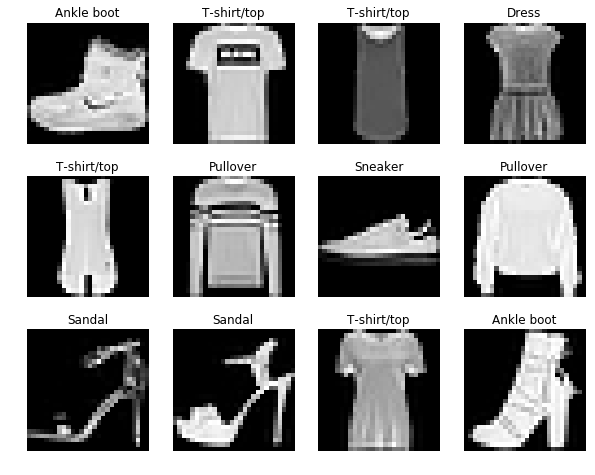

In [11]:
def plot_sample_gallery(images, labels):
    plt.figure(figsize=(10, 8))
    if hasattr(images, 'numpy'):
        images = images.numpy()
    for i, image, label in zip(range(12), images, labels):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image.reshape(28, 28), cmap=plt.cm.gray)
        plt.title(TARGET_NAMES[label])
        plt.axis('off')

        
plot_sample_gallery(images_train, labels_train)

In [12]:
def onehot_encode(num_classes, y):
    return np.eye(num_classes)[y]

In [13]:
scaled_images_train = images_train.astype(np.float32) / 255
scaled_images_test = images_test.astype(np.float32) / 255

train_ds = tf.data.Dataset.from_tensor_slices(
    (scaled_images_train, onehot_encode(10, labels_train)))
test_ds = tf.data.Dataset.from_tensor_slices(
    (scaled_images_test, onehot_encode(10, labels_test)))

In [14]:
scaled_images_train.dtype

dtype('float32')

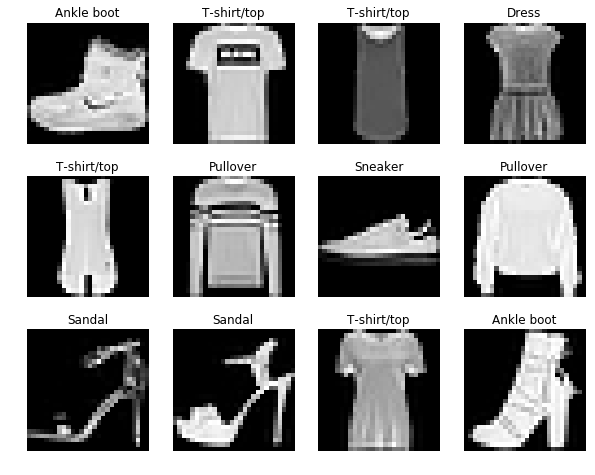

In [15]:
plot_sample_gallery(scaled_images_train, labels_train)

In [16]:
def single_image_data_augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=63 / 255.0)
    image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
    return image


def data_augment(input_tensor):
    return tf.map_fn(single_image_data_augment, input_tensor)

Let's plot some data augmented samples. **Rerun the execution of this sell several times using `ctrl-enter`** to see the random changes in constrast and horizontal flips happen:

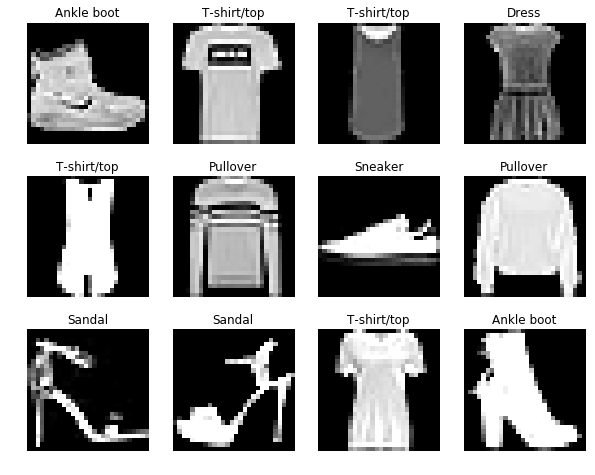

In [17]:
plot_sample_gallery(data_augment(images_train[:12]), labels_train)

In [ ]:
# Subsample a small training set with labels
iterator = tfe.Iterator(train_ds.shuffle(60000).batch(1000))
small_train_images, small_train_labels = next(iterator)
small_val_images, small_val_labels = next(iterator)
small_train_ds = tf.data.Dataset.from_tensor_slices(
    (small_train_images, small_train_labels))

## A first classification model

In [ ]:
class Model(tfe.Network):

    def __init__(self, data_format, dropout=0.5):
        super(Model, self).__init__(name='fashion-mnist')
        self._input_shape = get_batch_image_shape(
            image_size=(28, 28), data_format=data_format)
        self.conv1 = self.track_layer(
            tf.layers.Conv2D(32, 5, data_format=data_format, activation=tf.nn.relu))
        self.conv2 = self.track_layer(
            tf.layers.Conv2D(64, 5, data_format=data_format, activation=tf.nn.relu))
        self.fc1 = self.track_layer(tf.layers.Dense(1024, activation=tf.nn.relu))
        self.fc2 = self.track_layer(tf.layers.Dense(10))
        self.dropout = self.track_layer(tf.layers.Dropout(dropout))
        self.max_pool2d = self.track_layer(
            tf.layers.MaxPooling2D(
                (2, 2), (2, 2), padding='SAME', data_format=data_format))

    def call(self, inputs, training=False):
        # Compute the forward pass by plugin the parameterized layers
        # of the model along with parameter-free operations such as
        # max pooling and dropout.
        # The graph of the model is dynamically defined each time
        # we execute this forward pass.
        x = tf.reshape(inputs, self._input_shape)
        x = self.conv1(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.max_pool2d(x)
        x = tf.layers.flatten(x)
        x = self.fc1(x)
        if training:
            x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
def loss_from_logits(logits, targets):
    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(
             labels=targets, logits=logits))


def loss(model, inputs, targets):
    return loss_from_logits(model.call(inputs), targets)


def accuracy_from_logits(logits, targets):
    match = tf.equal(tf.argmax(logits, axis=1, output_type=tf.int32),
                     tf.argmax(targets, axis=1, output_type=tf.int32))
    return tf.reduce_mean(tf.cast(match, dtype=tf.float32))

In [ ]:
model = Model(get_data_format(), dropout=0.5)
model_ewa = Model(get_data_format(), dropout=0.5)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
grad = tfe.implicit_gradients(loss)

train_duration = 0
with tf.device(get_device()):
    for e in range(101):
        if e % 10 == 0:
            tic = time()
            train_loss = loss(model, small_train_images, small_train_labels).numpy()
            val_logits = model.call(small_val_images)
            val_loss = loss_from_logits(val_logits, small_val_labels).numpy()
            val_acc = accuracy_from_logits(val_logits, small_val_labels).numpy()
            eval_duration = time() - tic
            print("Epoch %d: train loss %f, val loss %f, val acc %0.3f, train time %0.3fs, eval time %0.3fs" %
                  (e, train_loss, val_loss, val_acc, train_duration, eval_duration))
        tic = time()
        for (inputs, targets) in tfe.Iterator(small_train_ds.shuffle(1000).batch(50)):
            optimizer.apply_gradients(grad(model, data_augment(inputs), targets, training=True))
        train_duration = time() - tic

In [ ]:
dataset_test_images, dataset_test_labels = next(tfe.Iterator(test_ds.batch(1000)))
print("Loss on test set: %0.4f" % loss(
    model, dataset_test_images, dataset_test_labels).numpy())

In [ ]:
labels_pred = model.predict(scaled_images_test).numpy().argmax(axis=1)

In [ ]:
test_acc = np.mean(labels_pred == labels_test)
print("Accuracy on test set: %0.3f" % test_acc)

In [ ]:
model_ewa.predict(scaled_images_test).numpy().argmax(axis=1)

In [ ]:
c1w = model_ewa.conv1.trainable_variables[0]

In [ ]:
model_ewa.conv1.trainable_variables[0]